## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [ ]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import sinogap_module as sg




### <font style="color:lightblue">Redefine</font>

In [ ]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [ ]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**10
    ,batchSplit = 2
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.00005
    ,learningRateG = 0.00001
)

sg.DCfg = sg.DCfgClass(16)


### <font style="color:lightblue">Raw Read</font>

In [4]:
trainSet = sg.createTrainSet()
testSet = sg.createTestSet()

Done
Loading train set 4 of 9: 18692b.MinceO ... Done
Loading train set 5 of 9: 19022g.11-EggLard ... Done
Loading train set 6 of 9: 19736b.09_Feb.4176862R_Eig_Threshold-4keV ... Done
Loading train set 7 of 9: 19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1 ... Done
Loading train set 8 of 9: 20982b.04_774784R ... Done
Loading train set 9 of 9: 23574.8965435L.Eiger.32kev_org ... Done
Loading test set ... Done


### <font style="color:lightblue">Show</font>

4.747e-01, 4.311e-02, 2.891e-01, 6.197e-01


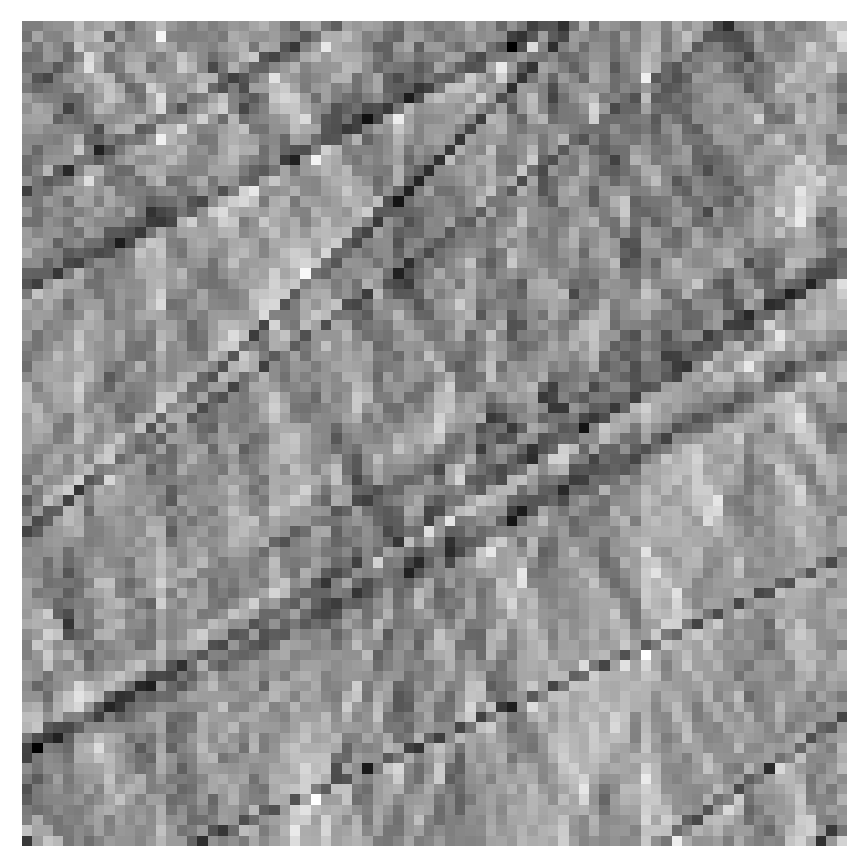

In [5]:
sg.refImages, sg.refNoises = sg.createReferences(testSet, 1)
sg.showMe(testSet, 0 )

## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)
        self.amplitude = 4
        self.encoders =  nn.ModuleList([
            self.encblock(  1/self.baseChannels,
                               1, 3, norm=False),
            self.encblock(  1, 1, 3),
            self.encblock(  1, 1, 3),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gap2/noBNreNorm4/model_gen.pt" )

generator2 = Generator2()
generator2 = generator2.to(sg.TCfg.device)
generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()
sg.lowResGenerators[2] = generator2



### Generator 4pix

In [7]:


class Generator4(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator4, self).__init__(4)
        self.amplitude = 4
        self.encoders =  nn.ModuleList([
            self.encblock( 1/self.baseChannels,
                              1, 3, norm=False),
            self.encblock( 1, 1, 3),
            self.encblock( 1, 2, 3, stride=2),
            self.encblock( 2, 2, 3),
            self.encblock( 2, 4, 3),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(8, 2, 3),
            self.decblock(4, 2, 3),
            self.decblock(4, 1, 4, stride=2),
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gap4/noBNreNorm4/model_gen.pt" )

generator4 = Generator4()
generator4 = generator4.to(sg.TCfg.device)
generator4 = generator4.requires_grad_(False)
generator4 = generator4.eval()
sg.lowResGenerators[4] = generator4





### Generator 8pix

In [8]:


class Generator8(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator8, self).__init__(8)
        self.amplitude = 4

        self.encoders =  nn.ModuleList([
            self.encblock( 1/self.baseChannels,
                              1, 3, norm=False),
            self.encblock( 1, 1, 3, dopadding=True),
            self.encblock( 1, 2, 3, stride=2),
            self.encblock( 2, 2, 3, dopadding=True),
            self.encblock( 2, 4, 3, stride=2),
            self.encblock( 4, 4, 3, dopadding=True),
            self.encblock( 4, 8, 3, stride=2),
            self.encblock( 8, 8, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(16, 8, 3, dopadding=True),
            self.decblock(16, 4, 4, stride=2),
            self.decblock( 8, 4, 3, dopadding=True),
            self.decblock( 8, 2, 4, stride=2),
            self.decblock( 4, 2, 3, dopadding=True),
            self.decblock( 4, 1, 4, stride=2),
            self.decblock( 2, 1, 3, dopadding=True),
            self.decblock( 2, 1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        sg.load_model(self, model_path="saves/gap8/noBNreNorm4/model_gen.pt" )

generator8 = Generator8()
generator8 = generator8.to(sg.TCfg.device)
generator8 = generator8.requires_grad_(False)
generator8 = generator8.eval()
sg.lowResGenerators[8] = generator8

### Generator 16pix

In [9]:


class Generator16(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator16, self).__init__(16,1)
        self.amplitude = 4

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (1+self.latentChannels) /self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, dopadding=True),
            self.decblock(32,  8, 4, stride=2),
            self.decblock(16,  8, 3, dopadding=True),
            self.decblock(16,  4, 4, stride=2),
            self.decblock( 8,  4, 3, dopadding=True),
            self.decblock( 8,  2, 4, stride=2),
            self.decblock( 4,  2, 3, dopadding=True),
            self.decblock( 4,  1, 4, stride=2),
            self.decblock( 2,  1, 3, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        sg.load_model(self, model_path="saves/gap16/noBNreNorm4/model_gen.pt" )

    def forward(self, input):

        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)
        stDev = modelIn.std(dim=(-1,-2))[...,None,None]

        if self.latentChannels :
            #latent = self.noise2latent(noises)
            latent = torch.zeros( images.shape[0], self.latentChannels, *self.sinoSh).to(sg.TCfg.device)
            dwTrain = [torch.cat((modelIn, latent), dim=1),]
        else :
            dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn ), dim=1 ))

        patches = modelIn[self.gapRng] + self.amplitude * stDev * res[self.gapRng]
        return sg.squeezeOrg(patches, orgDims)


generator16 = Generator16()
generator16 = generator16.to(sg.TCfg.device)
sg.lowResGenerators[16] = generator16




### <font style="color:lightblue">Generator</font>

In [10]:
sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)


Layer (type:depth-idx)                   Output Shape              Param #
Generator16                              [1, 1, 80, 16]            416,000
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-1                  [1, 64, 78, 78]           1,216
│    │    └─LeakyReLU: 3-2               [1, 64, 78, 78]           --
│    └─Sequential: 2-2                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-3                  [1, 64, 78, 78]           36,928
│    │    └─LeakyReLU: 3-4               [1, 64, 78, 78]           --
│    └─Sequential: 2-3                   [1, 128, 38, 38]          --
│    │    └─Conv2d: 3-5                  [1, 128, 38, 38]          73,856
│    │    └─LeakyReLU: 3-6               [1, 128, 38, 38]          --
│    └─Sequential: 2-4                   [1, 128, 38, 38]          --
│    │    └─Conv2d: 3-7                  [1, 128, 38, 38]          14

### <font style="color:lightblue">Discriminator</font>

In [11]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.body =  nn.Sequential(
            self.encblock( 1/self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            )
        self.head = self.createHead()
        #sg.load_model(self, model_path="/mnt/bctpro.data/anton/sinogap/saves/gap16/noBNreNorm_pureAdv/model_dis.pt" )


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1024, 3, 3]           --
│    └─Sequential: 2-1                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-1                  [1, 64, 78, 78]           640
│    │    └─LeakyReLU: 3-2               [1, 64, 78, 78]           --
│    └─Sequential: 2-2                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-3                  [1, 64, 78, 78]           36,928
│    │    └─LeakyReLU: 3-4               [1, 64, 78, 78]           --
│    └─Sequential: 2-3                   [1, 128, 38, 38]          --
│    │    └─Conv2d: 3-5                  [1, 128, 38, 38]          73,856
│    │    └─LeakyReLU: 3-6               [1, 128, 38, 38]          --
│    └─Sequential: 2-4                   [1, 128, 38, 38]          --
│    │    └─Conv2d: 3-7                  [1, 128, 38, 38]          147,584
│

## <font style="color:lightblue">Restore checkpoint</font>

Probabilities of reference images: Ref: 6.578e-01, Gen: 3.381e-01, Pre: 2.080e-01.
Distances of reference images: REC: 9.820e-04, MSE: 7.231e-04, L1L: 1.744e-02.


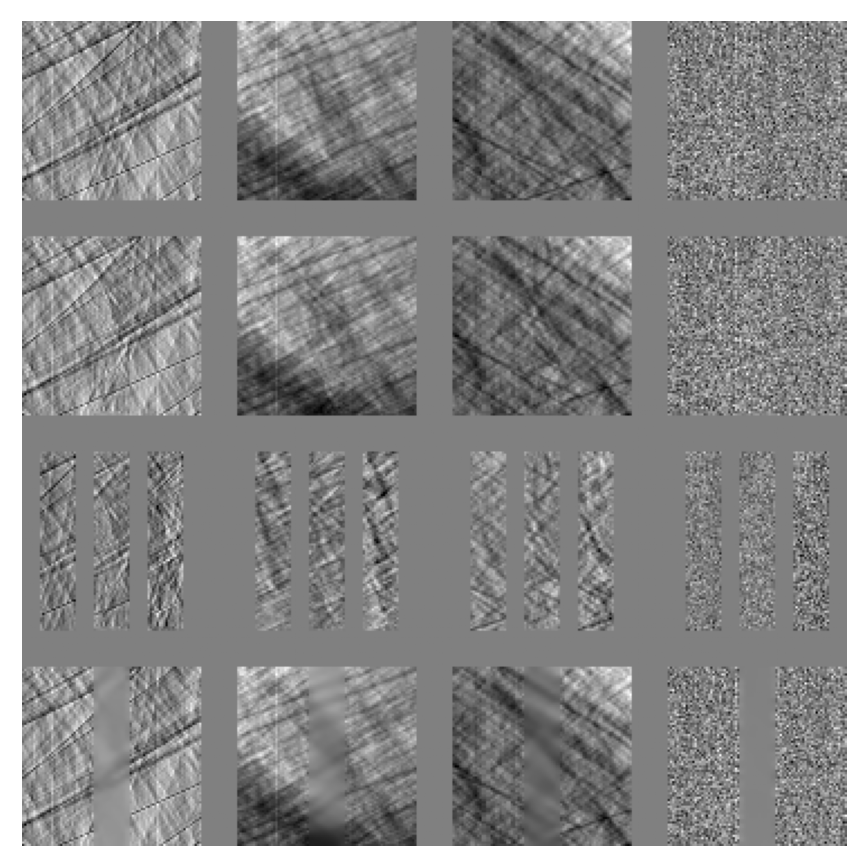

In [12]:

sg.scheduler_G = None # torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1.001)
sg.scheduler_D = None
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=0.999)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

In [ ]:
#print("amplitude: ", sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
#print(sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom)
#lastLR = sg.scheduler_D.get_last_lr()[0]
#print(f"Initial LR : {lastLR:.6e}  {lastLR/sg.TCfg.learningRateD:.3f}")
#print(f"{sg.normRec.item():e}, {sg.normMSE.item():e}, {sg.normL1L.item():e}")
#print(f"{sg.normTestRec.item():e}, {sg.normTestMSE.item():e}, {sg.normTestL1L.item():e}")
#sg.freeGPUmem()
#sg.load_model(sg.generator, model_path="saves/gap16/noBNreNorm4/model_gen.pt" )
#sg.initialTest()
#lastLR = sg.scheduler_G.get_last_lr()[0]
#print(f"Initial LR : {lastLR:.6e}  {lastLR/sg.TCfg.learningRateG:.3f}")




## <font style="color:lightblue">Execute</font>

lossDifCoef: 40.0
Epoch: 7 (4).  Dis[1.00]: 0.623 (0.624), Gen[1.00]: 0.956 (0.248), Rec: 1.693 (Train: 1.756, Test: 1.682 | 1.628).
TT: 0.95,  FT: 0.77,  HD: 5.845e+01,  GP: 0.066, 0.266 
TF: 0.14,  FF: 0.06,  LD: 3.362e-03,  R : 0.868.


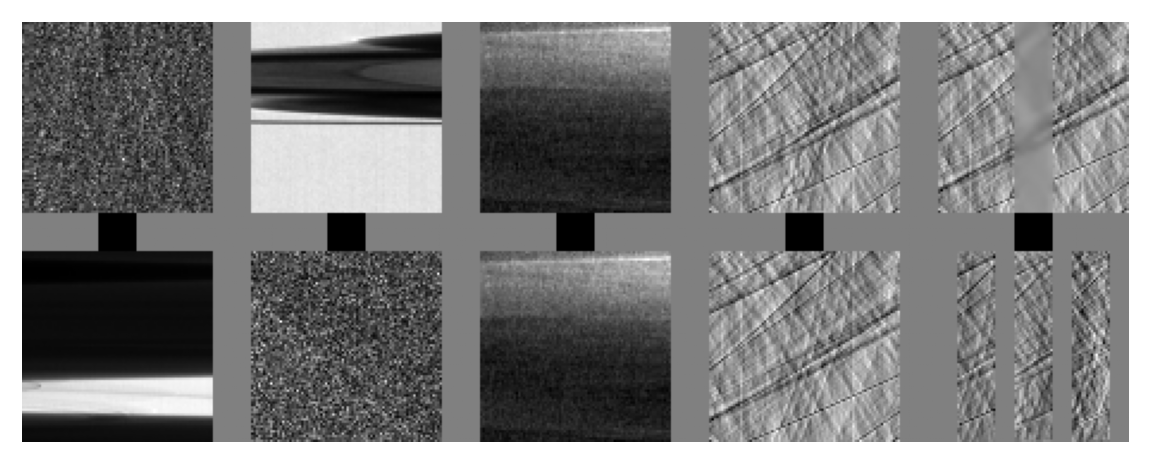

 99%|█████████▉| 8479/8582 [15:57:04<11:35,  6.75s/it]

In [ ]:
sg.noAdv = False
sg.dataLoader = sg.createDataLoader(trainSet, num_workers=16)
sg.testLoader = sg.createDataLoader(testSet , num_workers=16)
#sg.scheduler_G = None
#sg.scheduler_D = None




#sg.normRec, sg.normMSE, sg.normL1L, _ , _ = sg.summarizeSet(sg.dataLoader)
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L, _ , _ = sg.summarizeSet(sg.testLoader)
sg.normRec, sg.normMSE, sg.normL1L = 4.031e-03, 6.579e-03, 2.047e-02
sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 4.868e-03, 1.382e-03, 1.369e-02
if sg.epoch == 0 :
    if sg.normRec == 1:
        sg.normRec, sg.normMSE, sg.normL1L, _ , _ = sg.summarizeSet(sg.dataLoader)
        sg.normTestRec, sg.normTestMSE, sg.normTestL1L, _ , _ = sg.summarizeSet(sg.testLoader)
    #sg.minGdLoss = sg.normTestRec
    #with torch.no_grad(): sg.generator.amplitude[()] = -math.log(1+2/sg.normMSE)

#torch.autograd.set_detect_anomaly(True)

sg.epoch += 1
Rec_test, MSE_test, L1L_test, Rprob_test, Fprob_test, Dloss_test, GAloss_test, GDloss_test \
    = sg.summarizeSet(sg.testLoader, False)
sg.writer.add_scalars("Test per epoch",
                   {'MSE': MSE_test / sg.normTestMSE
                   ,'L1L': L1L_test / sg.normTestL1L
                   ,'REC': Rec_test / sg.normTestRec
                   #,'Dis': Dis_test
                   #,'Gen': Gen_test
                   }, sg.epoch )
sg.writer.add_scalars("Test losses per epoch",
                   { 'Dis': Dloss_test
                   , 'Adv': GAloss_test
                   , 'Gen': sg.lossAdvCoef * GAloss_test + sg.lossDifCoef * GDloss_test
                   }, sg.epoch )
sg.writer.add_scalars("Test probs per epoch",
                   {'Ref': Rprob_test
                   ,'Gen': Fprob_test
                   }, sg.epoch )



#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch


#lastLR = sg.scheduler_G.get_last_lr()[0]
#print(f"Initial LR : {lastLR:.6e}  {lastLR/sg.TCfg.learningRateG:.3f}")
#def my_beforeReport() :
#    lastLR = sg.scheduler_G.get_last_lr()[0]
#    print(f"LR : {lastLR:.6e} {lastLR/sg.TCfg.learningRateG:.3f}")
#    if sg.scheduler_G.get_last_lr()[0]  >  5 * sg.TCfg.learningRateG :
#        return
#    if sg.scheduler_G is not None :
#        sg.scheduler_G.step()
#    if sg.scheduler_D is not None :
#        sg.scheduler_D.step()
#    return
#sg.beforeReport = my_beforeReport

sg.lossAdvCoef = 1.0
sg.lossDifCoef = 40

#def my_beforeReport() :
#    sg.lossDifCoef = min (sg.lossDifCoef * 1.001, 100.0)
#    print(f"lossDifCoef: {sg.lossDifCoef}")
#    with open(f"message_{sg.TCfg.exec}.txt", 'a') as file:
#        file.write(f"lossDifCoef: {sg.lossDifCoef}\n")
#sg.beforeReport = my_beforeReport

try :
    sg.train(savedCheckPoint)
except :
    del sg.dataLoader
    del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()